<a href="https://colab.research.google.com/github/jyotidabass/Image-processing-in-medical-applications/blob/main/Image_processing_for_medical_applications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

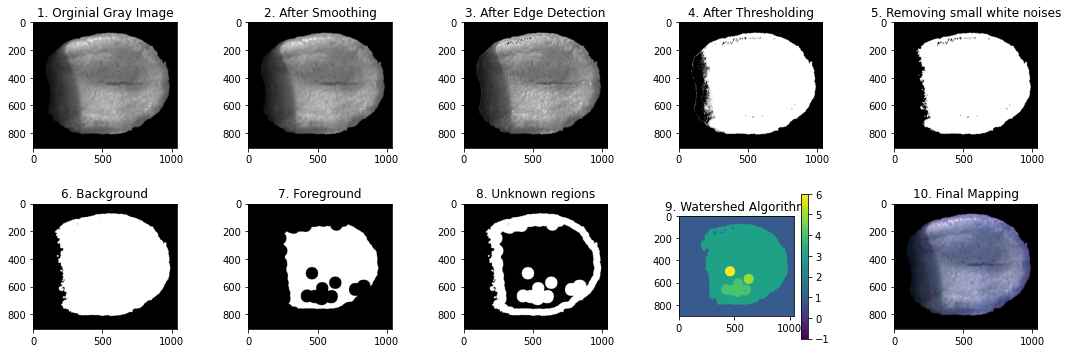

In [ ]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

def watershed(image):

    ###################PREPROCESSING

    #Read the image and convert to gray scale
    img = cv2.imread(image)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #smoothing the image
    img_median = cv2.medianBlur(img_gray,5)
    #edge detection using sobelX, sobelY
    img_sobelx = cv2.Sobel(img_median,cv2.CV_8U,dx=1,dy=0,ksize=3)
    img_sobely = cv2.Sobel(img_median,cv2.CV_8U,dx=0,dy=1,ksize=3)

    img_sobel = img_sobelx+img_sobely+img_gray

    ret, th1 = cv2.threshold(img_sobel,55,255,cv2.THRESH_BINARY)

    #having foreground and background image
    kernel = np.ones((3,3),np.uint8)
    # To remove any small white noises in the image using morphological opening
    opening = cv2.morphologyEx(th1, cv2.MORPH_OPEN,kernel,iterations=2)

    #background
    # Black region shows sure background area
    # Dilation increases object boundary to background.
    sure_bg = cv2.dilate(opening,kernel,iterations=3)

    #white region shows sure foreground region
    dist = cv2.distanceTransform(opening,distanceType=cv2.DIST_L2, maskSize=5)

    ret,sure_fg = cv2.threshold(dist, 0.2*dist.max(),255,0) #threshold value needs to change if tumor is not segmented 

    # Identifying regions where we don't know whether foreground and background
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)

    #######Waterhsed algorithm

    contours, hierarchy = cv2.findContours(sure_fg,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    #numpy array for amrkers 

    marker = np.zeros((img_gray.shape[0],img_gray.shape[1]),dtype=np.int32)
    marker = np.int32(sure_fg)+np.int32(sure_bg)

    #marker labeling

    for i in range(len(contours)):
        cv2.drawContours(marker,contours,i,i+2,-1)
    
    marker = marker + 1 #to make sure background is not black 0
    marker[unknown==255] = 0 #unknown regions as 0 

    copy_img = img.copy()
    cv2.watershed(copy_img,marker)

    copy_img[marker == -1] = [255,0,255]

    return img_gray,img_median, img_sobel, th1,opening,sure_bg,sure_fg,unknown,marker,copy_img

### Image data
image_path = '/content/cropped-1E6AE7E2-F4F6-4EFC-AFEC-75B6AF988C47 - Abhishek Karekar.jpg'

#preprocessing function
tumor = watershed(image_path)[0]
img_median = watershed(image_path)[1]
img_sobel = watershed(image_path)[2]
threshold = watershed(image_path)[3]
opening = watershed(image_path)[4]
sure_bg = watershed(image_path)[5]
sure_fg = watershed(image_path)[6]
unknown= watershed(image_path)[7]
marker = watershed(image_path)[8]
img_mapped = watershed(image_path)[9]
#####################################
## Plotting all stages of watershed algorithm ##
#####################################

fig, axs = plt.subplots(2,5, figsize=(18,6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .25, wspace=.5)

axs = axs.ravel()

axs[0].imshow(tumor,'gray')
axs[0].set_title('1. Orginial Gray Image')
axs[1].imshow(img_median,'gray')
axs[1].set_title('2. After Smoothing')
axs[2].imshow(img_sobel,'gray')
axs[2].set_title('3. After Edge Detection')
axs[3].imshow(threshold,'gray')
axs[3].set_title('4. After Thresholding')
axs[4].imshow(opening,'gray')
axs[4].set_title('5. Removing small white noises')
axs[5].imshow(sure_bg,'gray')
axs[5].set_title('6. Background')
axs[6].imshow(sure_fg,'gray')
axs[6].set_title('7. Foreground')
axs[7].imshow(unknown,'gray')
axs[7].set_title('8. Unknown regions')
axs[8].imshow(marker)
axs[8].set_title('9. Watershed Algorithm')
axs[9].imshow(img_mapped)
axs[9].set_title('10. Final Mapping')

fig.colorbar(axs[8].imshow(marker),ax=axs[8])

plt.show()